In [1]:
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Download data from MTA

In [2]:
# Load data for the month of June
url1 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190601.txt"
url2 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt"
url3 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt"
url4 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt"
url5 = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt"
df1 = pd.read_csv(url1)
df2 = pd.read_csv(url2)
df3 = pd.read_csv(url3)
df4 = pd.read_csv(url4)
df5 = pd.read_csv(url5)

In [91]:
df = pd.concat([df1, df2, df3, df4, df5])

In [92]:
# get rid of extra strings in columns 
df.columns = df.columns.str.replace(" ", "")

### Remove Outliers

In [93]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
count1 = df.count()[0]
df.describe()

,ENTRIES,EXITS
count,1027180.000,1027180.000
mean,42073092.644,34377301.295
std,213717105.321,196474576.462
min,0.000,0.000
25%,298971.000,119183.000
50%,2137858.500,1222591.500
75%,6745217.500,4591467.000
max,2129289036.000,2124055240.000


In [94]:
# IQR
Q1 = df['EXITS'].quantile(0.25)
Q3 = df['EXITS'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

4472284.0


In [95]:
high_outliers = Q3 + 1.5 * IQR
high_outliers

11299893.0

In [96]:
df = df.loc[df['EXITS'] < high_outliers]
count2 = df.count()[0]
df.describe()

,ENTRIES,EXITS
count,927624.000,927624.000
mean,6830582.348,2074271.400
std,35639949.026,2665955.143
min,0.000,0.000
25%,220753.500,79761.750
50%,1609554.000,883508.000
75%,5258838.250,3114614.500
max,1206003933.000,11299874.000


In [97]:
count2/count1

0.9030783309643879

### Calculate number of people in and out from cummulative values

In [98]:
# Use diff() to derrive the actual number of people from the culmulative value for entries and exits for each SCP
# abs() is used to account for the turnstiles that count backwards
df['people_in'] = df.groupby(['STATION', 'UNIT', 'SCP'])['ENTRIES'].transform(lambda x: x.diff().abs())
df['people_out'] = df.groupby(['STATION', 'UNIT', 'SCP'])['EXITS'].transform(lambda x: x.diff().abs())

In [99]:
# show which rows are NaN - each nan is at the beginning of a new scp
df[df['people_in'].isna()].head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,people_in,people_out
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,7071830,2396411,nan,nan
42,A002,R051,02-00-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6298050,1412557,nan,nan
84,A002,R051,02-03-00,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1236982,4651756,nan,nan
126,A002,R051,02-03-01,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,1115712,1720977,nan,nan
168,A002,R051,02-03-02,59 ST,NQR456W,BMT,05/25/2019,00:00:00,REGULAR,6200254,8353543,nan,nan


In [100]:
# Remove all nan data
df = df.dropna()

### Incorporate Jieun's analysis and select only the top 30 stations

In [101]:
# list of top 30 stations from Jieun's notebook
stations = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '59 ST', '14 ST', '125 ST',
       '104 ST', 'TIMES SQ-42 ST', 'DEKALB AV', '86 ST', 'FRANKLIN AV',
       '145 ST', '167 ST', 'LEXINGTON AV/53', '72 ST', 'GUN HILL RD',
       'BOWLING GREEN', 'FULTON ST', 'GRD CNTRL-42 ST', '66 ST-LINCOLN',
       'KINGS HWY', 'GRAND ST', 'KINGSBRIDGE RD', '34 ST-PENN STA',
       'CHAMBERS ST', 'FORDHAM RD', '116 ST', '96 ST', '50 ST',
       'FT HAMILTON PKY']

In [102]:
# select only top 30 stations from data frame
df = df[df['STATION'].isin(stations)]

### Filter stations that are in Silicon Alley

In [103]:
# Load table of silicon alley stations
silicon_alley = pd.read_csv('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/data/silicon_alley.csv')
#silicon_alley.head()

In [104]:
silicon_alley_str = silicon_alley.name

In [105]:
# we use this code to test whether stations in our top 30 are in sillicon alley
silicon_alley_str[silicon_alley_str.str.contains('Hamilton', regex=True)]

Series([], Name: name, dtype: object)

In [106]:
# filter top 30 based on stations that are in silicon alley
top_12_sa = ['23 ST', '42 ST-PORT AUTH', 'CANAL ST', '14 ST', 'TIMES SQ-42 ST', 'BOWLING GREEN',
             'FULTON ST', 'GRD CNTRL-42 ST', 'GRAND ST', '34 ST-PENN STA', 'CHAMBERS ST', '50 ST']
df = df[df['STATION'].isin(top_12_sa)]

In [107]:
df['STATION'].unique()

array(['TIMES SQ-42 ST', '23 ST', 'CANAL ST', 'CHAMBERS ST', 'FULTON ST',
       '50 ST', 'GRAND ST', '42 ST-PORT AUTH', '34 ST-PENN STA', '14 ST',
       'BOWLING GREEN', 'GRD CNTRL-42 ST'], dtype=object)

### Make Graphs showing frequency for time of day and day of week 

In [108]:
# Create a day of week column
df['DATE'] = pd.to_datetime(df['DATE'])
df['weekday'] = df['DATE'].dt.day_name()

In [109]:
# Remove Saturday and Sunday - we want to target commuters and street teams don't want to work on the weekend
df = df[~df['weekday'].isin(['Saturday', 'Sunday'])]

In [110]:
heat_df = df.filter(['weekday','STATION','people_out'], axis=1)
heat_df.head()

,weekday,STATION,people_out
2507,Monday,TIMES SQ-42 ST,214.000
2508,Monday,TIMES SQ-42 ST,41.000
2509,Monday,TIMES SQ-42 ST,91.000
2510,Monday,TIMES SQ-42 ST,424.000
2511,Monday,TIMES SQ-42 ST,444.000


In [111]:
heat_df = heat_df.pivot_table(index='weekday', columns='STATION', values='people_out', aggfunc='sum')

No handles with labels found to put in legend.


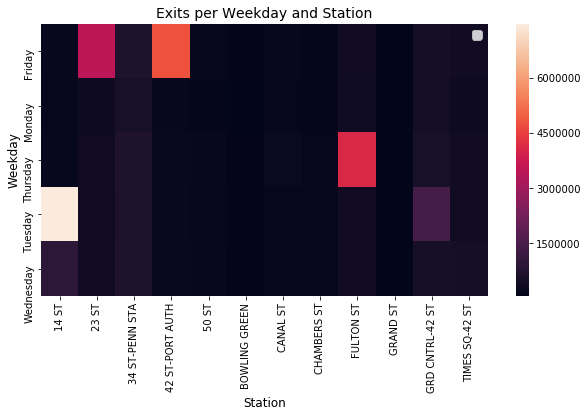

In [112]:
a4_dims = (10, 5)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.heatmap(heat_df)
plt.title('Exits per Weekday and Station', size=14)
plt.xlabel('Station', size=12)
plt.ylabel('Weekday', size=12)
plt.legend(fontsize=12);
plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/station_heat_map.svg')

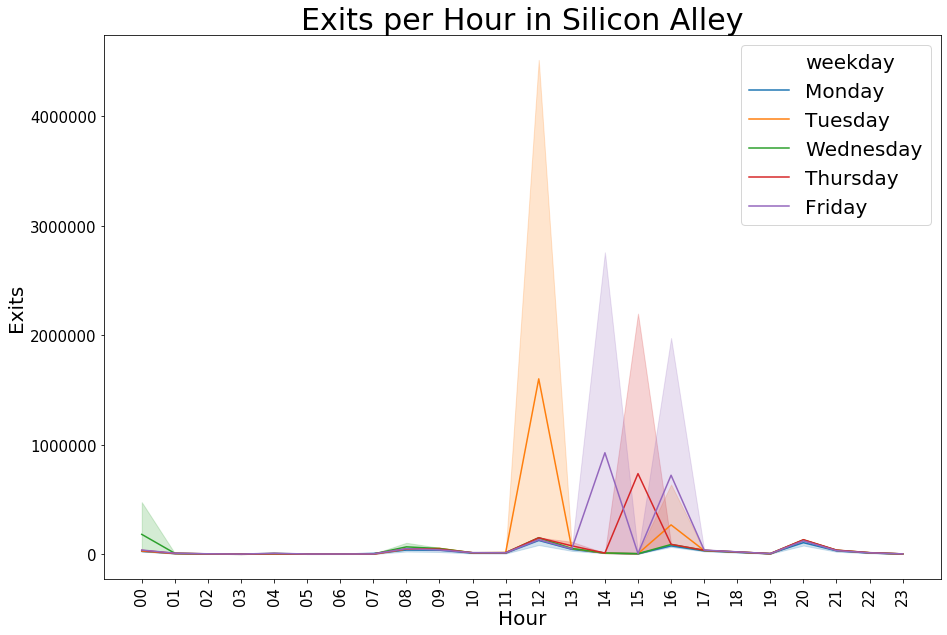

In [113]:
# Graph of time of day
df['hour'] = df['TIME'].astype(str).str[:2]

# Sort for presentation's sake
data = df[['DATE', 'hour', 'weekday', 'people_out']].groupby(
    ['DATE', 'weekday', 'hour'], as_index=False).sum()
data.sort_values(by=['hour', 'DATE', 'weekday'], inplace=True)
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=(a4_dims))
sns.lineplot(ax=ax, x='hour', y='people_out', hue='weekday', data=data)
plt.xticks(rotation='vertical', size=15)
plt.yticks(size=15)
plt.title('Exits per Hour in Silicon Alley', size=30)
plt.xlabel('Hour', size=20)
plt.ylabel('Exits', size=20)
plt.legend(fontsize=20)
#plt.savefig('/Users/AuerPower/Metis/git/NYC_turnstile_EDA/images/time_of_day.jpg')

### Map

In [ ]:
# Load shapefile using geopandas
import geopandas as gpd
import contextily as ctx

In [ ]:
fp = "/Users/AuerPower/Metis/git/NYC_turnstile_EDA/data/silicon_alley2.shp"
map_df = gpd.read_file(fp)

In [ ]:
map_df.plot()

In [ ]:
map_df.name.unique()

In [ ]:
map_df_stations = map_df.name

In [ ]:
# select only top 30 stations from data frame
map_df_stations[map_df_stations.str.contains('Grand', regex=True)]

In [ ]:
map_df_station_names = ['Times Sq - 42nd St', '23rd St', 'Chambers St', 'Fulton St',
                        '50th St','Grand St','42nd St - Port Authority Bus Term', 'Canal St', 
                        'Grand Central - 42nd St', '34th St - Penn Station', 
                       '14th St', 'Bowling Green']

In [ ]:
len(map_df_station_names)

In [ ]:
map_df = map_df[map_df['name'].isin(map_df_station_names)]

In [ ]:
# remove duplicate station locations
map_df = map_df.drop_duplicates(subset='name', keep="first")
map_df.plot()

In [ ]:
# Sort names so we can repalce them with the df names
map_df = map_df.sort_values(by='name')
map_df.name

In [ ]:
df = df.sort_values(by='STATION')
df.STATION.unique()

In [ ]:
# change station names in df to match map_df
map_df['name'].replace('14th St', '14 ST')
map_df['name'].replace('23rd St', '23 ST')
map_df['name'].replace('34th St - Penn Station', '34 ST-PENN STA')
map_df['name'].replace('42nd St - Port Authority Bus Term', '42 ST-PORT AUTH')
map_df['name'].replace('50th St', '50 ST')
map_df['name'].replace('Bowling Green', 'BOWLING GREEN')
map_df['name'].replace('Canal St', 'CANAL ST')
map_df['name'].replace('Chambers St', 'CHAMBERS ST')
map_df['name'].replace('Fulton St', 'FULTON ST')
map_df['name'].replace('Grand Central - 42nd St', 'GRD CNTRL-42 ST')
map_df['name'].replace('Grand St', 'GRAND ST')
map_df['name'].replace('Times Sq - 42nd St', 'TIMES SQ-42 ST')

In [ ]:
map_df.name

In [ ]:
#merged = map_df.set_index('name').join(df.set_index('STATION'))
#merged.head()

In [ ]:
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
ax.set_axis_off()